In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline 

In [3]:
float_id = '9099' # '9094'
fd = xr.open_mfdataset('Data/LowRes/' + float_id + 'SOOCNQC.nc')
JULD = pd.to_datetime(fd.JULD.values)

OSError: no files to open

In [7]:
# HELPER FUNCTIONS

#define a function that smooths using a boxcar filter (running mean)
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#interpolate the data onto the standard depth grid given by x_int
def interpolate(x_int, xvals, yvals):
    yvals_int = []
    for n in range(0, len(yvals)):
        yvals_int.append(np.interp(x_int, xvals[n, :], yvals[n, :]))
    #convert the interpolated data from a list to numpy array
    return np.asarray(yvals_int)

# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate(zi, data, depth_range):
    n_profs = len(data)
    zi_start = abs(zi - depth_range[0]).argmin()
    zi_end =  abs(zi - depth_range[1]).argmin()
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end]
    data = data[:, zi_start : zi_end]
    col_inv = []
    for n in range(0, len(data)):
        col_inv.append(np.trapz(data[n,:][~np.isnan(data[n,:])], zi_struct[n,:][~np.isnan(data[n,:])]))
    return col_inv

2015 2015-09-23 16:07:00.000001792 5458.115686991363 5425.014064630942
2015 2016-02-05 07:29:00.000003584 5198.149358658726 5288.2404903893785
2016 2016-09-28 23:48:59.999999232 5588.103334677541 5504.108425840645
2016 2017-01-30 06:03:59.999995648 5195.790901882247 5364.954252750951
2017 2017-10-04 14:48:59.999999232 5582.6956166650125 5495.974577707643
2017 2018-02-25 15:39:00.000001280 5076.597553999115 5259.9402612365875
2018 2018-11-19 14:17:00.000002816 5357.420920073629 5321.476747738033
2018 2019-03-23 10:46:00.000003072 4976.60774951691 5200.08346793003


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


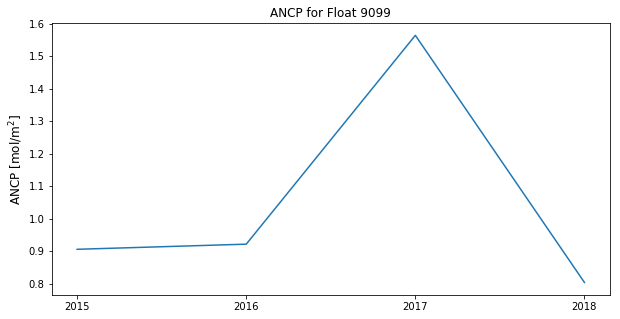

In [8]:
# Interpolate nitrate and poc
zi = np.arange(0, 1600, 5)
nitr_int = interpolate(zi, fd.Pressure[:, ::-1], fd.Nitrate[:, ::-1])

# Integrate nitrate and poc
nitr = np.array(integrate(zi, nitr_int, [25, 200]))

def find_extrema(data, date_range, find_func):
    # Find indices of float profiles in the date range
    date_mask = (JULD > date_range[0]) & (JULD < date_range[1])
    
    # Get the index where the data is closest to the find_func
    index = np.where(data[date_mask] == find_func(data[date_mask]))[0][0]
    
    # Get the average data for the month of the extrema
    month_start = JULD[date_mask][index].replace(day = 1)
    month_dates = (JULD > month_start) & (JULD < month_start + pd.Timedelta(days = 30))
    month_avg = np.mean(data[date_mask])
    
    return month_avg, JULD[date_mask][index], data[date_mask][index]

years = [2015, 2016, 2017, 2018]
nitr_extrema = []
nitr_ancp = []
for y in years:
    winter_range = [pd.datetime(y, 8, 1), pd.datetime(y, 12, 1)]
    summer_range = [pd.datetime(y, 12, 1), pd.datetime(y + 1, 4, 1)]

    # Find maximum winter and minimum summer nitrate
    avg_max_nitr, max_nitr_date, max_nitr = find_extrema(nitr, winter_range, np.max)
    avg_min_nitr, min_nitr_date, min_nitr = find_extrema(nitr, summer_range, np.min)
    
    
    # Convert to annual nitrate drawdown
    redfield_ratio = 106.0/16.0
    
    nitr_drawdown = (avg_max_nitr - avg_min_nitr)/1000.0 * redfield_ratio
    
    nitr_ancp.append(nitr_drawdown)
    
    nitr_extrema.append(((max_nitr, max_nitr_date), (min_nitr, min_nitr_date)))
    
    print(y, max_nitr_date, max_nitr, avg_max_nitr)
    print(y, min_nitr_date, min_nitr, avg_min_nitr)
    
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(years, nitr_ancp)
ax.set_ylabel('ANCP [mol/m$^2$]', size = 12) 
ax.set_xticks(years)
ax.set_xticklabels(['2015', '2016', '2017', '2018'])
ax.set_title('ANCP for Float ' + float_id)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  # This is added back by InteractiveShellApp.init_path()
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if sys.path[0] == '':


(4.5, 5.850744159326805)

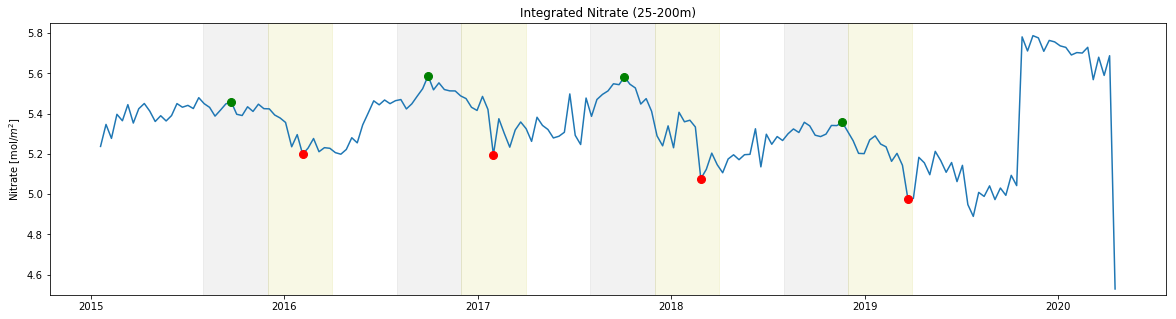

In [11]:
fig, ax = plt.subplots(figsize = (20, 5))

# Integrate nitrate and poc between given depth range
zi_range = [25, 200]
nitr_v = np.array(integrate(zi, nitr_int, zi_range))/1000.0

# Function to mark the maximum/minimum values of the data for summer and winter
def add_extrema(ax, ydata, extrema):
    for i in range(len(years)):
        y = years[i]
        winter_range = [pd.datetime(y, 8, 1), pd.datetime(y, 12, 1)]
        summer_range = [pd.datetime(y, 12, 1), pd.datetime(y + 1, 4, 1)]
        plt.axvspan(winter_range[0], winter_range[1], color='grey', alpha=0.1)
        plt.axvspan(summer_range[0], summer_range[1], color='y', alpha=0.1)

        (nmax, dmax), (nmin, dmin) = extrema[i]
        nitr_vmax = ydata[JULD == dmax]
        nitr_vmin = ydata[JULD == dmin]
        ax.plot([dmax], nitr_vmax, color = 'g', marker='o', markersize=8)
        ax.plot([dmin], nitr_vmin, color = 'r', marker='o', markersize=8)
    return ax 

#ax = plt.subplot(2, 1, 1)
ax.plot(JULD, nitr_v)
add_extrema(ax, nitr_v, nitr_extrema)
ax.set_ylabel('Nitrate [mol/$m^2$]')
ax.set_title('Integrated Nitrate (' + str(zi_range[0]) + '-' + str(zi_range[1]) + 'm)')
ax.set_ylim([4.5, ax.get_ylim()[1]])